<a href="https://colab.research.google.com/github/gbonar2008/232-069-MIT725-CAT2/blob/main/232_069CAT2_MIT725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# STEP 1: Install required packages
!pip install pandas numpy matplotlib scikit-learn tensorflow keras tcn

# STEP 2: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten
from tcn import TCN
import tensorflow as tf

ERROR: Could not find a version that satisfies the requirement tcn (from versions: none)
ERROR: No matching distribution found for tcn


In [20]:
# STEP 3: Load the dataset
url = "https://raw.githubusercontent.com/mkumakech/Covid-19_Pandemic/refs/heads/master/kano%20(1).csv"
df = pd.read_csv(url)
df = df[[ 'Confirmed', 'Discharged', 'Death']]
df = df.fillna(method='ffill')


<ipython-input-20-05bc3fd23c84>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [23]:
# STEP 4: Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [24]:
# STEP 5: Prepare time series data
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 10
X, y = create_sequences(scaled_data, seq_len)
X_train, y_train = X[:-10], y[:-10]
X_test, y_test = X[-10:], y[-10:]

In [25]:
# STEP 6: Define models
def build_lstm():
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(seq_len, 3)),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru():
    model = Sequential([
        GRU(64, activation='relu', input_shape=(seq_len, 3)),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn():
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(seq_len, 3)),
        MaxPooling1D(),
        Flatten(),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_tcn():
    model = Sequential([
        TCN(input_shape=(seq_len, 3)),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
LSTM MSE: 14.69


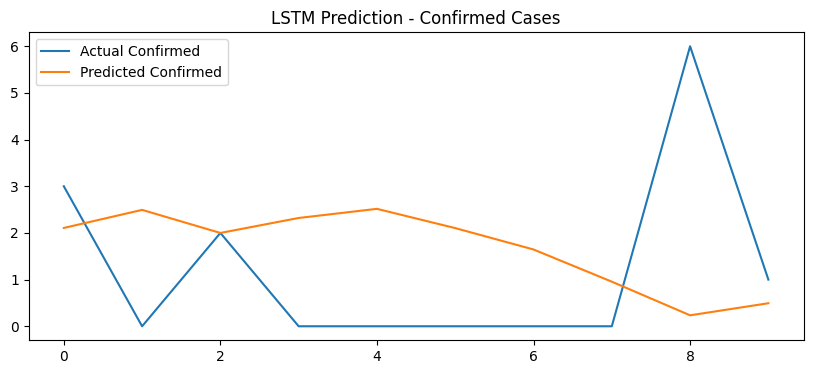

Training GRU...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
GRU MSE: 14.03


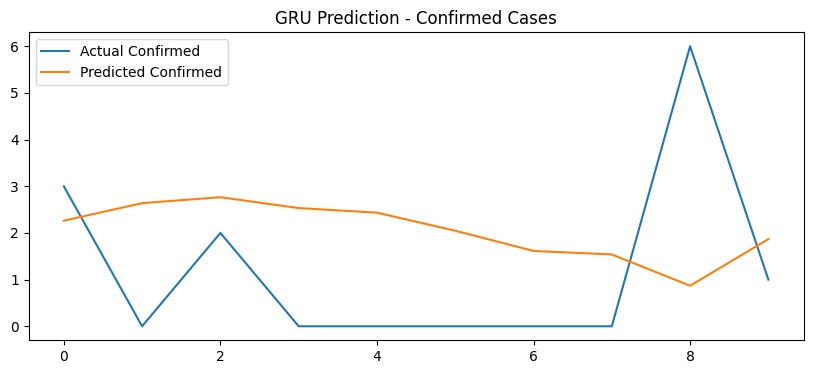

Training CNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
CNN MSE: 16.75


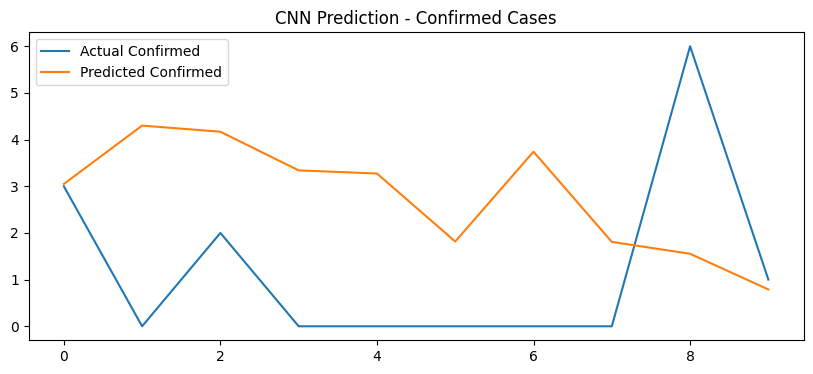

Training TCN...


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
TCN MSE: 25.12


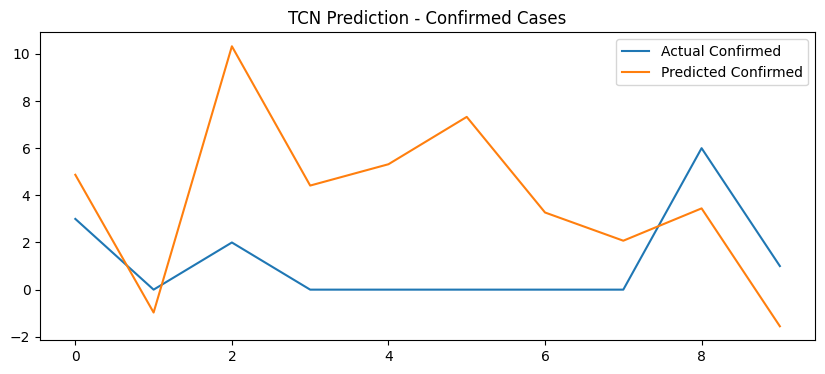

In [26]:
# STEP 7: Train and evaluate all models
def train_and_evaluate(model_func, name):
    print(f"Training {name}...")
    model = model_func()
    model.fit(X_train, y_train, epochs=50, verbose=0)
    pred = model.predict(X_test)
    pred_inverse = scaler.inverse_transform(pred)
    y_test_inverse = scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_test_inverse, pred_inverse)
    print(f"{name} MSE: {mse:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inverse[:, 0], label='Actual Confirmed')
    plt.plot(pred_inverse[:, 0], label='Predicted Confirmed')
    plt.title(f'{name} Prediction - Confirmed Cases')
    plt.legend()
    plt.show()

    return name, mse

results = []
for func, name in zip([build_lstm, build_gru, build_cnn, build_tcn], ['LSTM', 'GRU', 'CNN', 'TCN']):
    results.append(train_and_evaluate(func, name))

In [27]:
# STEP 8: Compare Models
best_model = sorted(results, key=lambda x: x[1])[0]
print(f"\nBest model: {best_model[0]} with MSE: {best_model[1]:.2f}")


Best model: GRU with MSE: 14.03
